In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from __future__ import division

import numpy as np

import scipy as sp
import scipy.special as sps
import scipy.linalg as sl
#from scipy.stats import ncx2

import matplotlib
import matplotlib.pyplot as plt

from pylab import figure
from numpy import random

matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'
matplotlib.rcParams['font.size'] = '20'

In [3]:
# useful routine for finding array element nearest to desired value
def find_nearest(array, value):
    idx = np.searchsorted(array, value, side="left")
    if np.abs(value - array[idx-1]) < np.abs(value - array[idx]):
        return idx-1, array[idx-1]
    else:
        return idx, array[idx]

In [4]:
# set some parameters for simulations
eps = 1.0e-2

# noise and signal variances
var1_0 = 1.0
var2_0 = 1.5
varh_0 = 0.3

# parameter arrays
var1_min = 0.0
var1_max = 3.0
N1 = 200;
var1 = np.linspace(var1_min+eps, var1_max, N1)
delta_v1 = var1[1]-var1[0]

var2_min = 0.0
var2_max = 3.0
N2 = 200;
var2 = np.linspace(var2_min+eps, var2_max, N2)
delta_v2 = var2[1]-var2[0]

varh_min = 0.0
varh_max = 3.0
Nh = 200;
varh = np.linspace(varh_min+eps, varh_max, Nh)
delta_vh = varh[1]-varh[0]

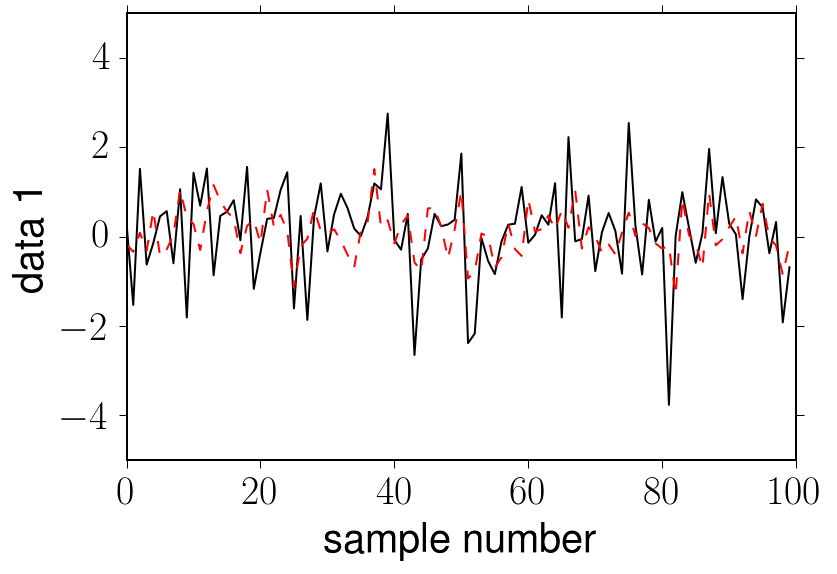

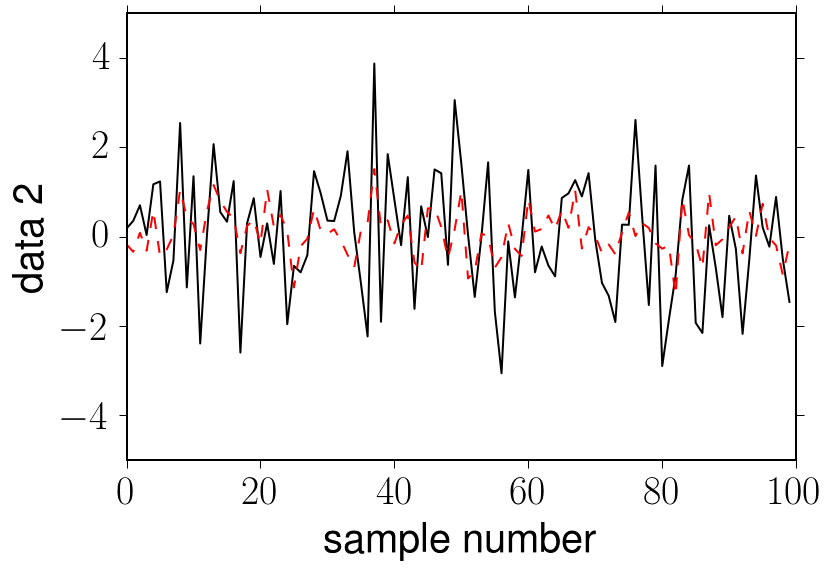

In [5]:
# simulate data

# number of samples
N = 100

# generate random samples
random.seed(1234)
n1 = random.normal(0, np.sqrt(var1_0), N)
n2 = random.normal(0, np.sqrt(var2_0), N)
h = random.normal(0, np.sqrt(varh_0), N)

d1 = h + n1
d2 = h + n2

# some common quantities
C11 = np.sum(d1**2)
C22 = np.sum(d2**2)
C12 = np.sum(d1*d2)

# plot data
plt.figure()
plt.rc('text', usetex=True)
plt.plot(d1, color='k')
plt.plot(h, linestyle='dashed', color='r')
plt.xlabel('sample number')
plt.ylabel('data 1')
plt.ylim((-5,5))
plt.savefig('./example-correlation-3params-data1.pdf', bbox_inches='tight', dpi=400)

plt.figure()
plt.rc('text', usetex=True)
plt.plot(d2, color='k')
plt.plot(h, linestyle='dashed', color='r')
plt.xlabel('sample number')
plt.ylabel('data 2')
plt.ylim((-5,5))
plt.savefig('./example-correlation-3params-data2.pdf', bbox_inches='tight', dpi=400)

# frequentist analysis

In [6]:
# frequentist estimators
Var1_hat = np.mean(d1**2)
Var2_hat = np.mean(d2**2)
varh_hat = np.mean(d1*d2)
var1_hat = Var1_hat - varh_hat
var2_hat = Var2_hat - varh_hat

# ML likelihood ratios
LambdaML = 1.0/(np.sqrt( (1-varh_hat**2/(Var1_hat*Var2_hat))**N ))
Lambda = 2*np.log(LambdaML)
Lambda_weak = N*varh_hat**2/(var1_hat*var2_hat)
                   
print "varh_hat (h)       = ", varh_hat
print "var1_hat (n1)      = ", var1_hat
print "var2_hat (n2)      = ", var2_hat
print "Var1_hat (d1=h+n1) = ", Var1_hat
print "Var2_hat (d2=h+n2) = ", Var2_hat

print "\nDetection statistic"
print "LambdaML      = ", LambdaML
print "Lambda        = ", Lambda
print "Lambda (weak) = ", Lambda_weak

varh_hat (h)       =  0.400419478545
var1_hat (n1)      =  0.783860308631
var2_hat (n2)      =  1.45550636053
Var1_hat (d1=h+n1) =  1.18427978718
Var2_hat (d2=h+n2) =  1.85592583907

Detection statistic
LambdaML      =  44.1370571023
Lambda        =  7.57459945341
Lambda (weak) =  14.0532770989


In [7]:
# calculate detection statistic Lambda 
def calLambda(V1_hat, V2_hat, vh_hat, N):
    LambdaML = 1.0/(np.sqrt( (1-vh_hat**2/(V1_hat*V2_hat))**N ))
    Lambda = 2*np.log(LambdaML)
    return Lambda

# bayesian analysis

In [8]:
# function for calculating joint posterior for noise-only model M0
# NOTE: ignores 1/(2pi)^N factor normalization
def joint_posterior_M0(v1, v2, C11, C22, N):
    
    # determinant of data covariance matrix
    detC = v1*v2
                
    # jeffrey's prior for var1, var2
    p1 = 1.0/v1 
    p2 = 1.0/v2 
                
    # likelihood for signal+noise model M1
    fac = (1.0/np.sqrt(detC))**N
    Q = -0.5*(C11/v1 + C22/v2)
    jp_M0 = fac * np.exp(Q) * p1 * p2    
      
    return jp_M0

In [9]:
# function for calculating joint posterior for signal+noise model M1
# NOTE: ignores 1/(2pi)^N factor normalization
def joint_posterior_M1(v1, v2, vh, vh_max, C11, C22, C12, N):
    
    # combined variances (detector output)
    V1 = v1 + vh
    V2 = v2 + vh
            
    # determinant of data covariance matrix
    detC = V1*V2 - vh*vh
                
    # jeffrey's prior for var1, var2; flat prior for varh
    p1 = 1.0/v1 
    p2 = 1.0/v2 
    ph = 1.0/vh_max
                
    # likelihood for signal+noise model M1
    fac = (1.0/np.sqrt(detC))**N
    Q = -0.5*(1.0/detC)*(V1*C22 + V2*C11 - 2.0*vh*C12)
    jp_M1 = fac * np.exp(Q) * p1 * p2 * ph   
      
    return jp_M1

In [10]:
# calculate bayes factor BF_10

# numerator ####################

# initialize
posterior = np.zeros(Nh)
integral = np.zeros(Nh)

for ii in range(0,Nh):
    # do marginalization integrals over sigma_1^2 and sigma_2^2
    for jj in range(0,N1):
            
        temp=0.0
        for kk in range(0,N2):
            
            # variances of signal and noise
            vh = varh[ii]
            v1 = var1[jj]
            v2 = var2[kk]
            vh_max = varh_max 
            
            # calculate value of joint posterior for model M1
            jp = joint_posterior_M1(v1, v2, vh, vh_max, C11, C22, C12, N)
            
            # integrate
            temp = temp + jp*delta_v2
            
        integral[jj] = temp
    
    # integrate again
    posterior[ii] = np.sum(integral*delta_v1)
    
# do final marginalization integral over sigma_h^2
numerator = np.sum(posterior*delta_vh)

# denominator ####################

# initialize
posterior = np.zeros(N1)

for ii in range(0,N1):
    
    temp=0.0
    # do marginalization integral over sigma_2^2
    for jj in range(0,N2):
        
        # variances of signal and noise
        v1 = var1[ii]
        v2 = var2[jj]
        
        # calculate value of joint posterior for model M0
        jp = joint_posterior_M0(v1, v2, C11, C22, N)
        
        # integrate
        temp = temp + jp*delta_v2
            
    posterior[ii] = temp
    
# do final marginalization integral over sigma_1^2
denominator = np.sum(posterior*delta_v1)

# calculate bayes factor
BF = numerator/denominator
twoLnBF = 2.0*np.log(BF)

print "bayes factor = ", BF
print "2ln BF       = ", twoLnBF

bayes factor =  10.0451906362
2ln BF       =  4.61418795262


In [11]:
# calculate marginalized posterior for sigma_1^2 given M0

# initialize
posterior = np.zeros(N1)

# calculate posterior by doing marginalization integrals
for ii in range(0,N1):
    
    temp=0.0
    for jj in range(0,N2):
        
        # variances of signal and noise
        v1 = var1[ii]
        v2 = var2[jj]
            
        # calculate value of joint posterior
        jp = joint_posterior_M0(v1, v2, C11, C22, N)
            
        # integrate
        temp = temp + jp
            
    posterior[ii] = temp
    
# normalize posterior
posterior = posterior/(np.sum(posterior)*delta_v1)
    
posterior_1_M0 = posterior

In [12]:
# calculate marginalized posterior for sigma_2^2 given M0

# initialize
posterior = np.zeros(N2)

# calculate posterior by doing marginalization integrals
for ii in range(0,N2):
    
    temp=0.0
    for jj in range(0,N1):
        
        # variances of signal and noise
        v2 = var2[ii]
        v1 = var1[jj]
            
        # calculate value of joint posterior
        jp = joint_posterior_M0(v1, v2, C11, C22, N)
            
        # integrate
        temp = temp + jp
            
    posterior[ii] = temp
    
# normalize posterior
posterior = posterior/(np.sum(posterior)*delta_v2)
    
posterior_2_M0 = posterior

In [13]:
# calculate marginalized posterior for sigma_1^2 given M1

# initialize
posterior = np.zeros(N1)
integral = np.zeros(N2)

# calculate posterior by doing marginalization integrals
for ii in range(0,N1):
    for jj in range(0,N2):
            
        temp=0.0
        for kk in range(0,Nh):
            
            # variances of signal and noise
            v1 = var1[ii]
            v2 = var2[jj]
            vh = varh[kk]
            vh_max = varh_max

            # calculate value of joint posterior
            jp = joint_posterior_M1(v1, v2, vh, vh_max, C11, C22, C12, N)
            
            # integrate
            temp = temp + jp
            
        integral[jj] = temp
    
    # integrate again
    posterior[ii] = np.sum(integral)

# normalize posterior
posterior = posterior/(np.sum(posterior)*delta_v1)
    
posterior_1_M1 = posterior

In [14]:
# calculate marginalized posterior for sigma_2^2 given M1

# initialize
posterior = np.zeros(N2)
integral = np.zeros(N1)

# calculate posterior by doing marginalization integrals
for ii in range(0,N2):
    for jj in range(0,N1):
            
        temp=0.0
        for kk in range(0,Nh):
            
            # variances of signal and noise
            v2 = var2[ii]
            v1 = var1[jj]
            vh = varh[kk]
            vh_max = varh_max
            
            # calculate value of joint posterior
            jp = joint_posterior_M1(v1, v2, vh, vh_max, C11, C22, C12, N)
            
            # integrate
            temp = temp + jp
            
        integral[jj] = temp
    
    # integrate again
    posterior[ii] = np.sum(integral)
    
# normalize posterior
posterior = posterior/(np.sum(posterior)*delta_v2)
    
posterior_2_M1 = posterior

In [15]:
# calculate marginalized posterior for sigma_h^2 given M1

# initialize
posterior = np.zeros(Nh)
integral = np.zeros(N1)

# calculate marginalized posterior by doing marginalization integrals
for ii in range(0,Nh):
    for jj in range(0,N1):
            
        temp=0.0
        for kk in range(0,N2):
            
            # variances of signal and noise
            vh = varh[ii]
            v1 = var1[jj]
            v2 = var2[kk]
            vh_max = varh_max 
            
            # calculate value of joint posterior
            jp = joint_posterior_M1(v1, v2, vh, vh_max, C11, C22, C12, N)
            
            # integrate
            temp = temp + jp
            
        integral[jj] = temp
    
    # integrate again
    posterior[ii] = np.sum(integral)
    
# normalize posterior
posterior = posterior/(np.sum(posterior)*delta_vh)
    
posterior_h_M1 = posterior

In [27]:
# find CL% bayesian credible region around the peaks of the distribution
def find_credible(array, dx, CL):
    
    N = len(array)
    idx = np.argmax(array)
    
    area = 0.0
    ctr = 0
    while area < 0.95:
        if idx-ctr <= 0:
            idx_1 = 0
        else:
            idx_1 = idx-ctr

        if idx+ctr >=N:
            idx_2 = N-1
        else:
            idx_2 = idx+ctr
        
        area = sum(array[idx_1:idx_2]*dx)
        ctr = ctr+1
    
    idx_low = idx - ctr
    idx_high = idx + ctr
    
    return idx_low, idx_high

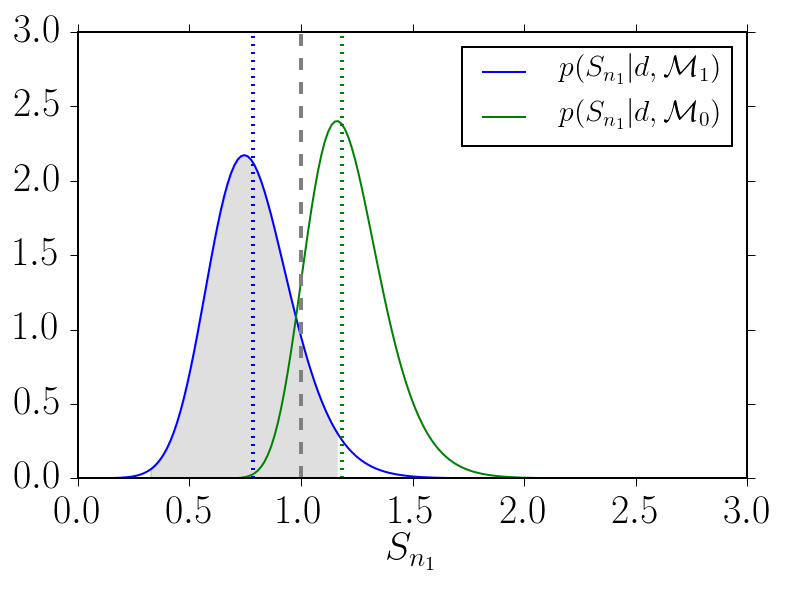

In [28]:
# make plot of posteriors for sigma_1^2
plt.figure()
plt.rc('text', usetex=True)
plt.plot(var1, posterior_1_M1, 'b')
plt.plot(var1, posterior_1_M0, 'g')
plt.plot((var1_0, var1_0), (0, 3), color='grey', linewidth=2, linestyle='dashed')
plt.plot((var1_hat, var1_hat), (0, 3), color='b', linewidth=2, linestyle='dotted')
plt.plot((Var1_hat, Var1_hat), (0, 3), color='g', linewidth=2, linestyle='dotted')

# find 95% credible region around the peaks of the distribution
idx_low, idx_high = find_credible(posterior_1_M1, delta_v1, 0.95)
plt.fill_between(var1, np.zeros(N1), posterior_1_M1, \
                 where=var1[idx_low]<=varh, color='grey', alpha=0.25)
plt.fill_between(var1, np.zeros(N1), posterior_1_M1, where=var1[idx_high]<=var1, color='white')

plt.xlabel(r'$S_{n_1}$')
plt.legend([r'$p(S_{n_1}|d,{\cal M}_1)$', r'$p(S_{n_1}|d,{\cal M}_0)$'], fontsize=15)
plt.savefig('./example-correlation-3params-posterior1.pdf', bbox_inches='tight', dpi=400)

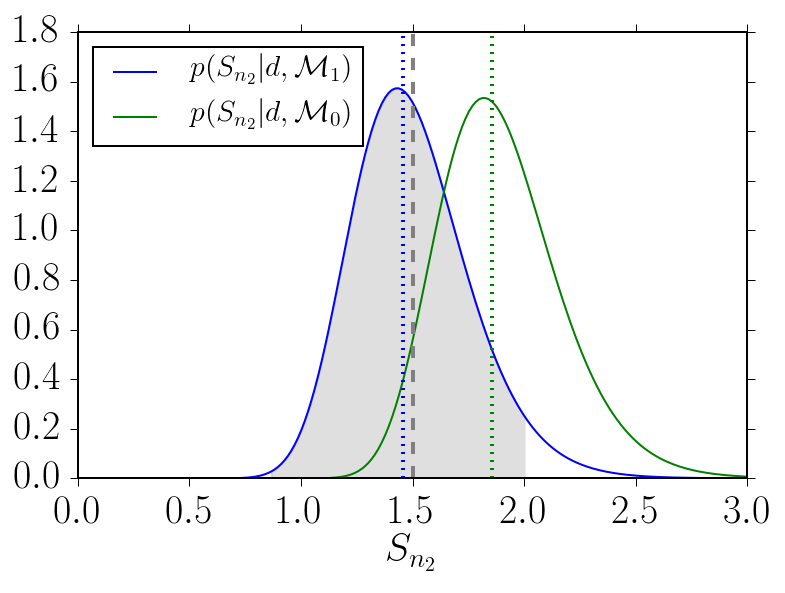

In [29]:
# make plot of posteriors for sigma_2^2
plt.figure()
plt.rc('text', usetex=True)
plt.plot(var2, posterior_2_M1, 'b')
plt.plot(var2, posterior_2_M0, 'g')
plt.plot((var2_0, var2_0), (0, 1.8), color='grey', linewidth=2, linestyle='dashed')
plt.plot((var2_hat, var2_hat), (0, 1.8), color='b', linewidth=2, linestyle='dotted')
plt.plot((Var2_hat, Var2_hat), (0, 1.8), color='g', linewidth=2, linestyle='dotted')

# find 95% credible region around the peaks of the distribution
idx_low, idx_high = find_credible(posterior_2_M1, delta_v2, 0.95)
plt.fill_between(var2, np.zeros(N2), posterior_2_M1, \
                 where=var1[idx_low]<=varh, color='grey', alpha=0.25)
plt.fill_between(var2, np.zeros(N2), posterior_2_M1, where=var2[idx_high]<=var2, color='white')

plt.xlabel(r'$S_{n_2}$')
plt.legend([r'$p(S_{n_2}|d,{\cal M}_1)$', r'$p(S_{n_2}|d,{\cal M}_0)$'], fontsize=15, loc='upper left')
plt.savefig('./example-correlation-3params-posterior2.pdf', bbox_inches='tight', dpi=400)

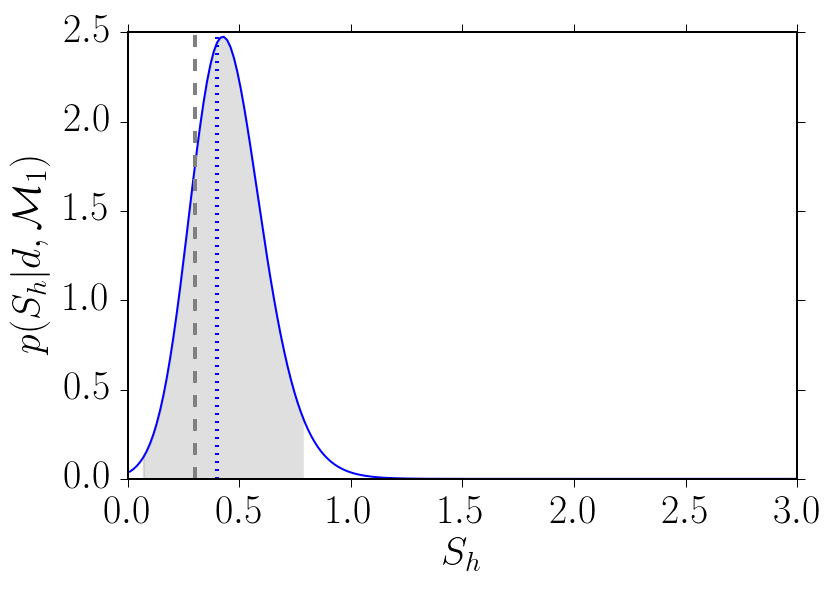

In [30]:
# make plot of posterior for sigma_h^2
plt.figure()
plt.rc('text', usetex=True)
plt.plot(varh, posterior_h_M1, 'b')
plt.plot((varh_0, varh_0), (0, 2.5), color='grey', linewidth=2, linestyle='dashed')
plt.plot((varh_hat, varh_hat), (0, 2.5), color='b', linewidth=2, linestyle='dotted')

# find 95% credible region around the peaks of the distribution
idx_low, idx_high = find_credible(posterior_h_M1, delta_vh, 0.95)
plt.fill_between(varh, np.zeros(Nh), posterior_h_M1, \
                 where=varh[idx_low]<=varh, color='grey', alpha=0.25)
plt.fill_between(varh, np.zeros(Nh), posterior_h_M1, where=varh[idx_high]<=varh, color='white')

plt.xlabel(r'$S_h$')
plt.ylabel(r'$p(S_h|d,{\cal M}_1)$')
plt.savefig('./example-correlation-3params-posteriorh.pdf', bbox_inches='tight', dpi=400)